# Logistic Regression with Wisconsin Breast Cancer Dataset

In [1]:
from sklearn.datasets import load_breast_cancer

In [2]:
data = load_breast_cancer()
print(dir(data))

['DESCR', 'data', 'data_module', 'feature_names', 'filename', 'frame', 'target', 'target_names']


## Business Understanding

In [3]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Every sample contains features of the nuclei (plural form on nucleus) of a person. Malignant cases are considered dangerous or potential cancer. Benign cases are considered harmless.

## Data Understanding

### Description of the data

There are in total 569 samples, each containing 30 numeric features. 212 samples are labeled as malignant (0) and the remaining 357 samples are considered benign (1).

The first 10 features contain the mean values of the characteristics of the nuclei. The next 10 features contain the standard error values of the characteristics. Lastly, the final 10 features contain the worst cases.

With the check below, we can do a quick check if there are any missing values in the dataset. If there is a `NaN` value in the dataset, the sum of the data will also be `NaN`. So, if the output of the cell below is `True`, there is at least one missing value in the dataset.

In [4]:
import numpy as np

np.isnan(np.sum(data.data))

False

The output is `False`. Therefore, there are no `NaN` values in the dataset.

### Feature characteristics

For every feature, the mean and standard deviation is calculated below.

In [5]:
X = data.data
y = data.target
feature_names = data.feature_names

for i in range(X.shape[1]):
    mean = round(np.mean(X[:, i]), 2)
    std = round(np.std(X[:, i]), 2)
    print(data.feature_names[i])
    print("Mean:", mean)
    print("Standard deviation:", std)
    print()

mean radius
Mean: 14.13
Standard deviation: 3.52

mean texture
Mean: 19.29
Standard deviation: 4.3

mean perimeter
Mean: 91.97
Standard deviation: 24.28

mean area
Mean: 654.89
Standard deviation: 351.6

mean smoothness
Mean: 0.1
Standard deviation: 0.01

mean compactness
Mean: 0.1
Standard deviation: 0.05

mean concavity
Mean: 0.09
Standard deviation: 0.08

mean concave points
Mean: 0.05
Standard deviation: 0.04

mean symmetry
Mean: 0.18
Standard deviation: 0.03

mean fractal dimension
Mean: 0.06
Standard deviation: 0.01

radius error
Mean: 0.41
Standard deviation: 0.28

texture error
Mean: 1.22
Standard deviation: 0.55

perimeter error
Mean: 2.87
Standard deviation: 2.02

area error
Mean: 40.34
Standard deviation: 45.45

smoothness error
Mean: 0.01
Standard deviation: 0.0

compactness error
Mean: 0.03
Standard deviation: 0.02

concavity error
Mean: 0.03
Standard deviation: 0.03

concave points error
Mean: 0.01
Standard deviation: 0.01

symmetry error
Mean: 0.02
Standard deviation: 0.

The values vary from very small values (1e-2) to large values (1e2). Normalizing the values between 0 and 1 is therefore necessary.

### Feature correlations
It is possible that there are features that are highly correlated with other features. If a feature is highly correlated with another feature, it will not contribute anything extra to the model. In the cell below, the Person correlation coefficient between a feature and all other features that are highly correlated with it, are displayed.

In [6]:
high_coeff_thld = 0.8

all_coeff = np.corrcoef(X, rowvar=False)
for i in range(len(feature_names)):
    coeff = all_coeff[i]
    high_coeff_idx = np.argwhere((coeff > high_coeff_thld) & (coeff < 0.999999))
    print(feature_names[i].upper().center(50, '*'))
    print("is highly correlated with the following features")
    print("-"*50)
    for idx in high_coeff_idx:
        print(f"{feature_names[idx][0]} ({np.round_(coeff[idx][0], 3)})")
    print()

*******************MEAN RADIUS********************
is highly correlated with the following features
--------------------------------------------------
mean perimeter (0.998)
mean area (0.987)
mean concave points (0.823)
worst radius (0.97)
worst perimeter (0.965)
worst area (0.941)

*******************MEAN TEXTURE*******************
is highly correlated with the following features
--------------------------------------------------
worst texture (0.912)

******************MEAN PERIMETER******************
is highly correlated with the following features
--------------------------------------------------
mean radius (0.998)
mean area (0.987)
mean concave points (0.851)
worst radius (0.969)
worst perimeter (0.97)
worst area (0.942)

********************MEAN AREA*********************
is highly correlated with the following features
--------------------------------------------------
mean radius (0.987)
mean perimeter (0.987)
mean concave points (0.823)
area error (0.8)
worst radius (0.963)
w

## Data Preparation

The data can be considered already prepared. The only remaining transformations that are required are normalization and feature selection. Before doing so, the data will be shuffled and the test set will be isolated from the training and evaluation set.

In [7]:
X_y = np.append(X, y.reshape(-1, 1), axis=1)
np.random.shuffle(X_y)

In [8]:
split_trainval_test = 0.2
n = X_y.shape[0]
n_test = int(n * split_trainval_test)
X_y_test = X_y[:n_test]
X_y_trainval = X_y[n_test:]

In [9]:
X_test = X_y_test[:, :-1]
y_test = X_y_test[:, -1]

X_trainval = X_y_trainval[:, :-1]
y_trainval = X_y_trainval[:, -1]

Based on the feature correlations in the previous section, a subset of the features is selected. Features that are correlated with other features do not further enrich the data and can therefore be excluded. The subset of features that are not significantly correlated with each other are selected in the cell below.

In [10]:
rem_features = np.array(
    ['mean radius', 'mean texture', 'mean smoothness',
     'mean compactness', 'mean symmetry', 'mean fractal dimension',
     'radius error', 'texture error', 'smoothness error',
     'compactness error', 'concave points error', 'symmetry error',
     'worst symmetry', 'worst fractal dimension'])
rem_features_idx = [np.where(feature_names == f)[0][0] for f in rem_features]
X_trainval = X_trainval[:, rem_features_idx]

In the cell below, the values are normalized per feature, the bias is added as a pseudo-feature, and finally the train and validation data are separated.

A very small value is added (`np.spacing(0)`) in the normalization of the values, in order to prevent a divide by zero error.

The pseudo-feature contains only the value 1. This is done in order to include the calculation of the partial derivative with respect to the bias bias in the same calculation of the partial derivative with respect to the weights (`calc_gradient()`).

In [11]:
X_trainval = X_y_trainval[:, :-1]
y_trainval = X_y_trainval[:, -1]

X_trainval /= np.max(X_trainval)
X_trainval = X_trainval / (X_trainval.max(axis=0) + np.spacing(0))

X_trainval = np.hstack((np.ones(X_trainval.shape[0]).reshape(-1, 1), X_trainval))

X_val = X_trainval[:n_test]
X_train = X_trainval[n_test:]
y_val = y_trainval[:n_test]
y_train = y_trainval[n_test:]

## Modeling

In this section the weights and model are initialized and then trained using batch gradient descent.

In [12]:
def sigmoid(X, w):
    return 1/(1+np.exp(-X.dot(w)))

def calc_gradient(w, x, y):
    y_hat = sigmoid(x, w)
    error = (y_hat - y)
    return (1.0/len(x)) * error.dot(x)


def calc_cost(y_hat, y):
    return -1/len(y) * np.sum(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))

In the cell below, `alpha` is the learning rate and `epsilon` is the tolerance value. If the sum of the difference between the new weights and the old weights is less than the tolerance value, the gradient descent stops.

In [13]:
w = np.zeros(X_train.shape[1])
alpha = 0.1
epsilon = 1e-3
history = []

In [14]:
epochs = 1
while True:
    gradient = calc_gradient(w, X_train, y_train)
    new_w = w - alpha * gradient
    
    if np.sum(abs(new_w - w)) < epsilon:
        print("Convergence reached!\n")
        break

    w = new_w

    cost_train = calc_cost(sigmoid(X_train, w), y_train)
    cost_val = calc_cost(sigmoid(X_val, w), y_val)
    
    if epochs % 10000 == 0:
        print("Iteration:", epochs)
        print("Cost training:", cost_train)
        print("Cost validation:", cost_val, "\n")
    epochs += 1
    history.append((cost_train, cost_val, w))

print("Total number of iterations:", epochs)
print("Final cost training:", calc_cost(sigmoid(X_train, w), y_train))
print("Final cost validation:", calc_cost(sigmoid(X_val, w), y_val))

Iteration: 10000
Cost training: 0.10034388699452561
Cost validation: 0.15039813106975133 

Iteration: 20000
Cost training: 0.07658868602643445
Cost validation: 0.14164247167805977 

Iteration: 30000
Cost training: 0.06530403829360139
Cost validation: 0.1403227506843078 

Iteration: 40000
Cost training: 0.058236807064355293
Cost validation: 0.14081414679468582 

Convergence reached!

Total number of iterations: 43498
Final cost training: 0.05630500675306721
Final cost validation: 0.14117212609800686


## Evaluation

This section contains the evaluation of the model. This includes the progression of the gradient descent, the calculation of the observation types, and the calculation of different metrics using the observation types.

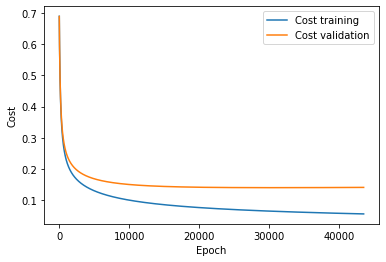

In [15]:
import matplotlib.pyplot as plt

cost_train_h, cost_val_h, w_h = np.array(history, dtype=object).T
total_epochs = list(range(len(history)))

plt.plot(total_epochs, cost_train_h, label="Cost training")
plt.plot(total_epochs, cost_val_h, label="Cost validation")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.legend()
plt.show()

In [16]:
iteration_lowest_cost_val = np.where(cost_val_h == np.min(cost_val_h))[0][0]
print("Iteration with the lowest cost validation:", iteration_lowest_cost_val)

Iteration with the lowest cost validation: 30601


The epoch with the lowest cost for the validation set is used as an index to find the corresponding weights (and bias). Using these weights, the probabilities and predictions are calculated. Based on the predictions, the observation types (true positives, true negatives, false positives, false negatives) are calculated. Finally, using the observation types, different metric values are calculated. Including the accuracy, precision, recall, and f1-score.

The threshold is set at 0.5. So, if the model is 50% or more sure that the output is benign (1), it will classify that sample as benign. Else, it will be classified as malignant (0).

In [17]:
threshold = 0.5

probabilities_val = sigmoid(X_val, w_h[iteration_lowest_cost_val])
predictions_val = np.where(probabilities_val >= threshold, 1, 0)

In [18]:
def calc_observation_types(y, y_hat):
    tp = np.sum(np.where((y == y_hat) & (y_hat == 1), 1, 0))
    tn = np.sum(np.where((y == y_hat) & (y_hat == 0), 1, 0))
    fp = np.sum(np.where((y != y_hat) & (y_hat == 1), 1, 0))
    fn = np.sum(np.where((y != y_hat) & (y_hat == 0), 1, 0))
    
    return (tp, tn, fp, fn)

def calc_accuracy(tp, tn, fp, fn):
    return (tp+tn)/(tp+tn+fp+fn)

def calc_precision(tp, fp):
    return tp/(tp+fp)

def calc_recall(tp, fn):
    return tp/(tp+fn)

def calc_fbeta_score(recall, precision, beta=1):
    return ((1+beta**2) * precision * recall) / (beta**2 * precision + recall)

In [19]:
class_distribution_trainval = np.sum(y_trainval)/len(y_trainval)
print("Class distribution of the training set and validation set:", round(class_distribution_trainval, 2))

Class distribution of the training set and validation set: 0.62


Since the class distribution of the training set and validation set is not heavily skewed. The accuracy of the model is not a metric to disregard. However, if this was the case, a different threshold other than 0.5 should have been selected based on the precision, recall, F1-score, and ROC curve.

In [20]:
tp, tn, fp, fn = calc_observation_types(y_val, predictions_val)
accuracy = calc_accuracy(tp, tn, fp, fn)
precision = calc_precision(tp, fp)
recall = calc_recall(tp, fn)
f1_score = calc_fbeta_score(recall, precision)

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(precision, 3))
print("F1 score:", round(f1_score, 3))

Accuracy: 0.947
Precision: 0.936
Recall: 0.936
F1 score: 0.961
